# Lesson 6 Exercise: Visualize Attention Patterns in Pretrained Models (SOLUTION)

**Estimated Time:** 18 minutes

This is the complete solution showing all implementations.

---

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

from data import load_jigsaw_dataset

from attention_utils import (
    plot_attention_heatmap,
    plot_multihead_attention,
    plot_layer_progression,
    extract_attention_patterns,
    print_attention_patterns
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("\n✓ Setup complete!")

Using device: cpu

✓ Setup complete!


---

# Part A: Extract and Visualize Basic Attention

## Step 1: Load BERT and Tokenizer

In [2]:
print("Loading BERT model and tokenizer...\n")

model_name = 'bert-base-uncased'

# SOLUTION: Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# SOLUTION: Load model with output_attentions=True
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# SOLUTION: Move to device and set eval mode
model.to(device)
model.eval()

print("✓ BERT loaded successfully!")

Loading BERT model and tokenizer...

✓ BERT loaded successfully!
✓ BERT loaded successfully!


## Step 2: Process Example Text

In [3]:
print("Loading example text for attention visualization...\n")

# SOLUTION: Load Jigsaw dataset (or fallback to synthetic)
comments = load_jigsaw_dataset(n_samples=1000)

# SOLUTION: Select a good example for visualization (medium length, clear content)
# Find comments with good length for attention visualization (10-30 tokens)
good_examples = [c for c in comments if 10 < c['length'] < 30]

if good_examples:
    example_text = good_examples[0]['text']
else:
    # Fallback to a curated example if none found
    example_text = "The bank can refuse to lend money to the person by the river bank."

print("Example Text:")
print(f"  '{example_text}'\n")

# SOLUTION: Tokenize
inputs = tokenizer(example_text, return_tensors='pt', add_special_tokens=True)

# SOLUTION: Move to device
inputs = {k: v.to(device) for k, v in inputs.items()}

# SOLUTION: Get tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print("\nTokenization:")
print(f"  Tokens: {tokens}")
print(f"  Number of tokens: {len(tokens)}")

Loading example text for attention visualization...

Loading Toxic Comment Classification dataset...
Requesting 1000 samples...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

✓ Loaded 1000 comments from civil_comments dataset

Example Text:
  'Kay's is one of the best bars in the city, but you don't have a section for the neighborhood.'


Tokenization:
  Tokens: ['[CLS]', 'kay', "'", 's', 'is', 'one', 'of', 'the', 'best', 'bars', 'in', 'the', 'city', ',', 'but', 'you', 'don', "'", 't', 'have', 'a', 'section', 'for', 'the', 'neighborhood', '.', '[SEP]']
  Number of tokens: 27


## Step 3: Examine Position IDs

In [4]:
print("Positional Encoding:")

# SOLUTION: Extract or create position_ids
if 'position_ids' in inputs:
    position_ids = inputs['position_ids'][0].tolist()
else:
    seq_len = inputs['input_ids'].shape[1]
    position_ids = torch.arange(seq_len, dtype=torch.long, device=device).tolist()

print(f"  Position IDs: {position_ids}")
print("\n💡 Key Insight:")
print("   These position IDs tell BERT the order of tokens.")
print("   Unlike RNNs, Transformers process all tokens in parallel!")

Positional Encoding:
  Position IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

💡 Key Insight:
   These position IDs tell BERT the order of tokens.
   Unlike RNNs, Transformers process all tokens in parallel!


## Step 4: Extract Attention Weights

In [5]:
print("Running model to extract attention weights...\n")

# SOLUTION: Run forward pass
with torch.no_grad():
    outputs = model(**inputs)

# SOLUTION: Extract attention
attention_weights = outputs.attentions

print("Attention Structure:")
print(f"  Number of layers: {len(attention_weights)}")
print(f"  Shape per layer: {attention_weights[0].shape}")
print(f"  Format: (batch_size, n_heads, seq_len, seq_len)")
print("\n✓ Attention weights extracted!")

Running model to extract attention weights...

Attention Structure:
  Number of layers: 12
  Shape per layer: torch.Size([1, 12, 27, 27])
  Format: (batch_size, n_heads, seq_len, seq_len)

✓ Attention weights extracted!
Attention Structure:
  Number of layers: 12
  Shape per layer: torch.Size([1, 12, 27, 27])
  Format: (batch_size, n_heads, seq_len, seq_len)

✓ Attention weights extracted!


## Step 5: Plot Attention Heatmap

Visualizing Layer 6, Head 0...



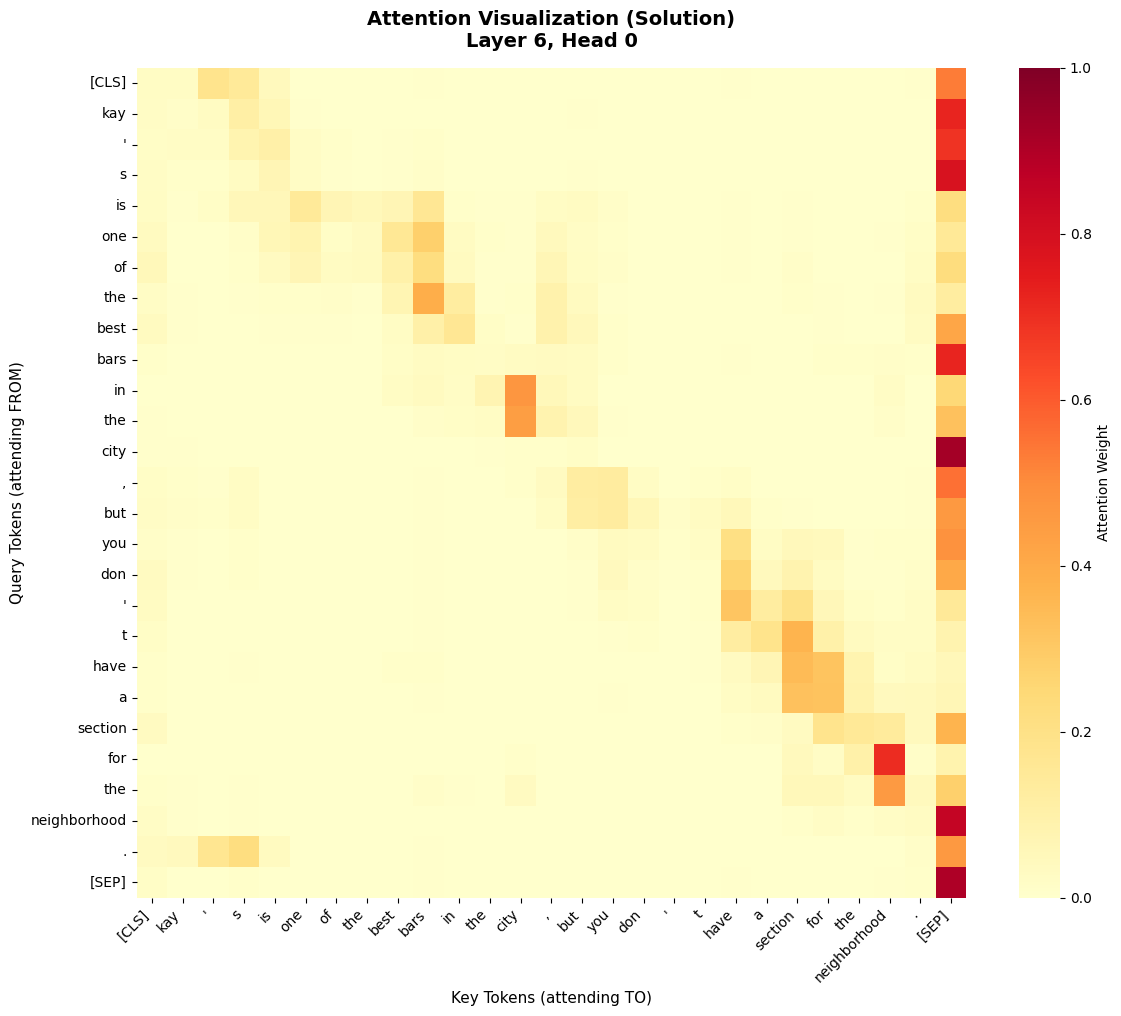

ATTENTION PATTERNS (Top-3 attended tokens per query)

'[CLS]' (pos 0) attends to:
  • '[SEP]' (pos 26): 0.533
  • ''' (pos 2): 0.182
  • 's' (pos 3): 0.148

'kay' (pos 1) attends to:
  • '[SEP]' (pos 26): 0.725
  • 's' (pos 3): 0.112
  • 'is' (pos 4): 0.062

''' (pos 17) attends to:
  • 'have' (pos 19): 0.313
  • 'section' (pos 21): 0.196
  • '[SEP]' (pos 26): 0.152

's' (pos 3) attends to:
  • '[SEP]' (pos 26): 0.789
  • 'is' (pos 4): 0.067
  • 's' (pos 3): 0.028

'is' (pos 4) attends to:
  • '[SEP]' (pos 26): 0.220
  • 'bars' (pos 9): 0.162
  • 'one' (pos 5): 0.148

'one' (pos 5) attends to:
  • 'bars' (pos 9): 0.278
  • 'best' (pos 8): 0.156
  • '[SEP]' (pos 26): 0.153

'of' (pos 6) attends to:
  • '[SEP]' (pos 26): 0.228
  • 'bars' (pos 9): 0.219
  • 'best' (pos 8): 0.100

'the' (pos 23) attends to:
  • 'neighborhood' (pos 24): 0.454
  • '[SEP]' (pos 26): 0.278
  • 'for' (pos 22): 0.054

... (16 more tokens)


In [6]:
layer_idx = 5  # Layer 6
head_idx = 0

print(f"Visualizing Layer {layer_idx+1}, Head {head_idx}...\n")

# SOLUTION: Extract attention matrix
attn_layer = attention_weights[layer_idx][0]  # (n_heads, seq_len, seq_len)
attn_head = attn_layer[head_idx].cpu().numpy()  # (seq_len, seq_len)

# SOLUTION: Plot heatmap
fig = plot_attention_heatmap(
    attn_head,
    tokens,
    title="Attention Visualization (Solution)",
    layer=layer_idx+1,
    head=head_idx,
    figsize=(12, 10)
)
plt.show()

# Print patterns
patterns = extract_attention_patterns(attn_head, tokens, top_k=3)
print_attention_patterns(patterns, max_tokens=8)

---

# Part B: Compare Multiple Attention Heads

Comparing 4 attention heads from Layer 6...



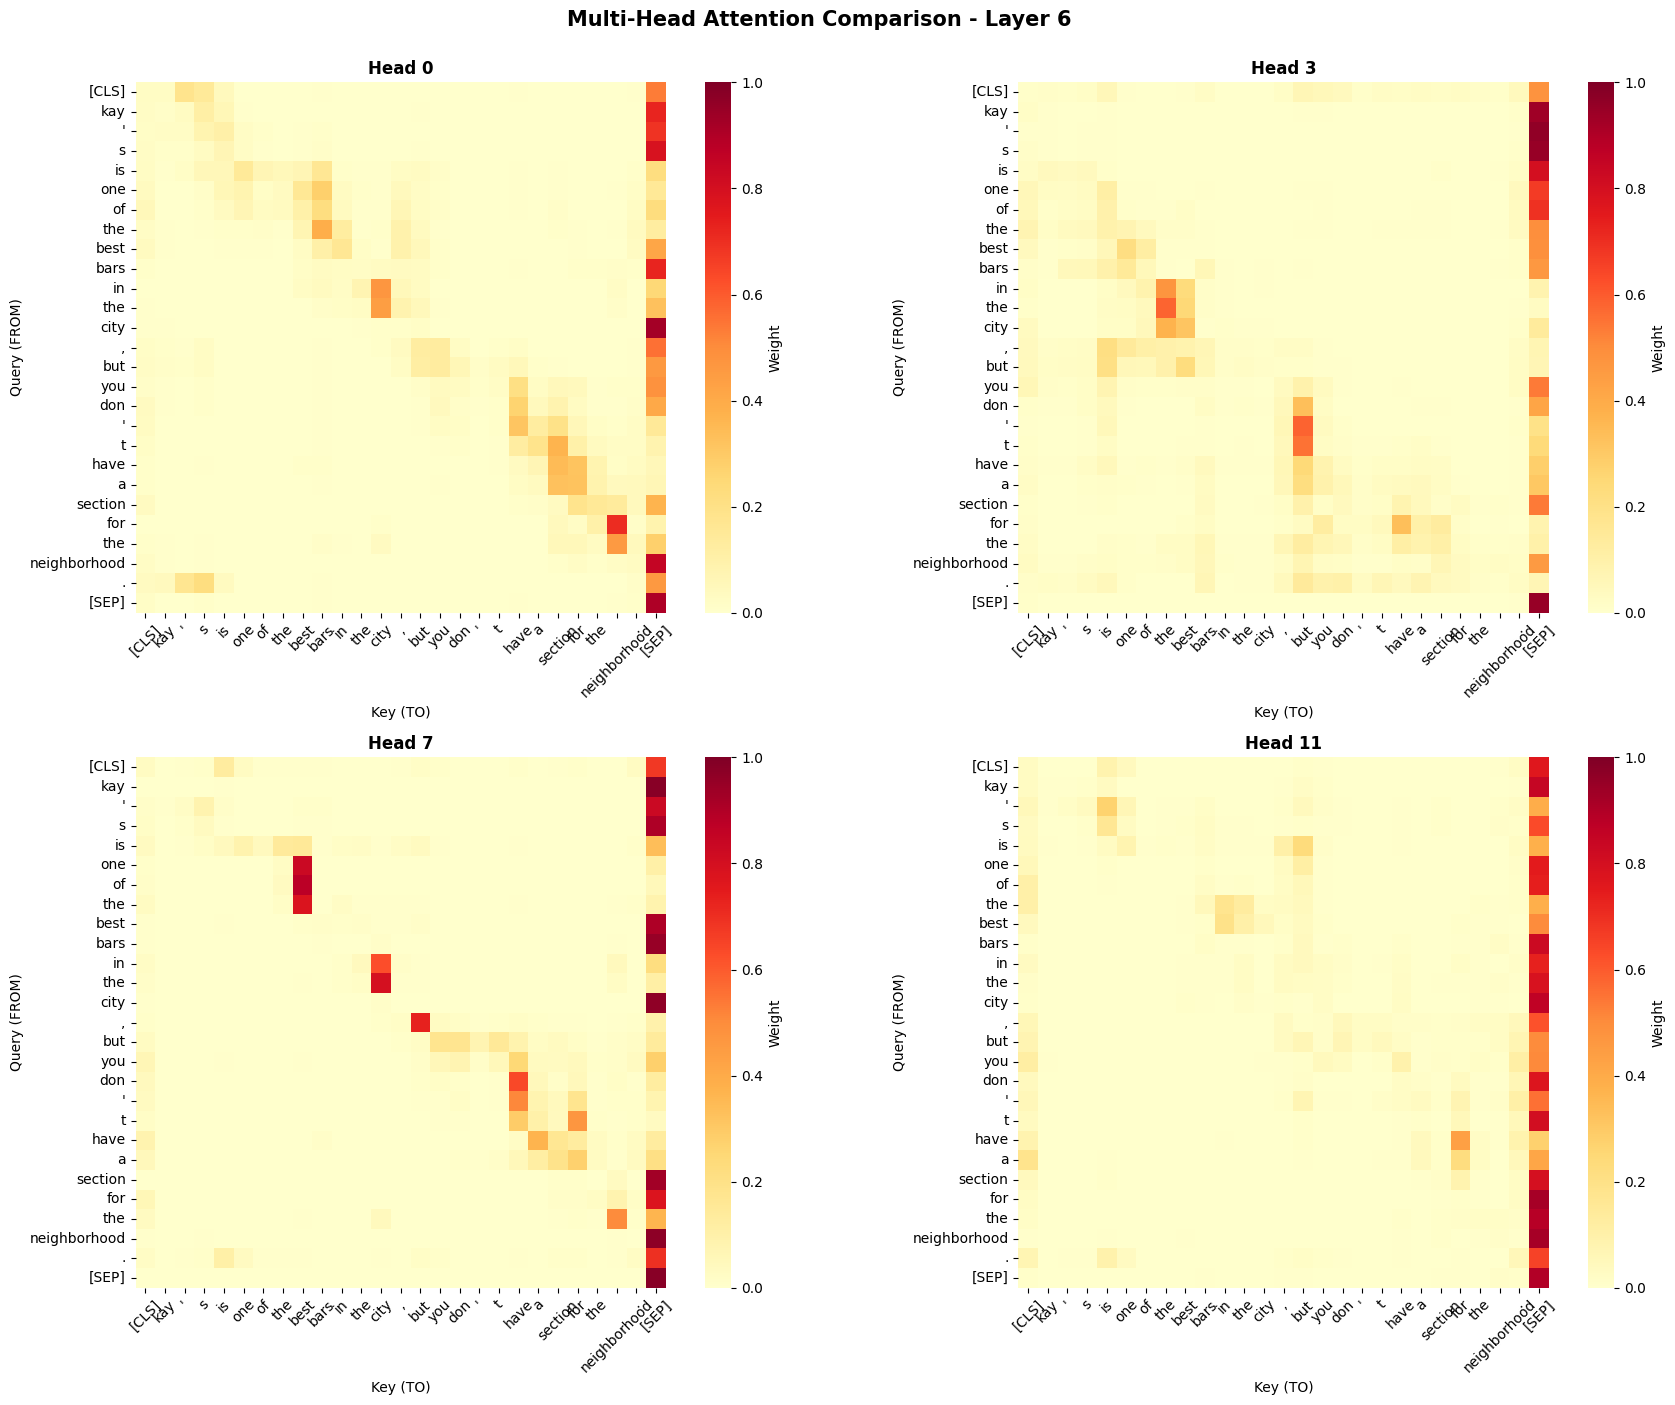

In [7]:
layer_idx = 5  # Layer 6
heads_to_compare = [0, 3, 7, 11]

print(f"Comparing {len(heads_to_compare)} attention heads from Layer {layer_idx+1}...\n")

# SOLUTION: Extract all heads
attn_layer = attention_weights[layer_idx][0].cpu().numpy()  # (n_heads, seq_len, seq_len)

# SOLUTION: Plot comparison
fig = plot_multihead_attention(
    attn_layer,
    tokens,
    layer=layer_idx+1,
    heads=heads_to_compare,
    figsize=(18, 14)
)
plt.show()

---

# Part C: Analyze Layer-by-Layer Attention

Comparing Head 0 across multiple layers...



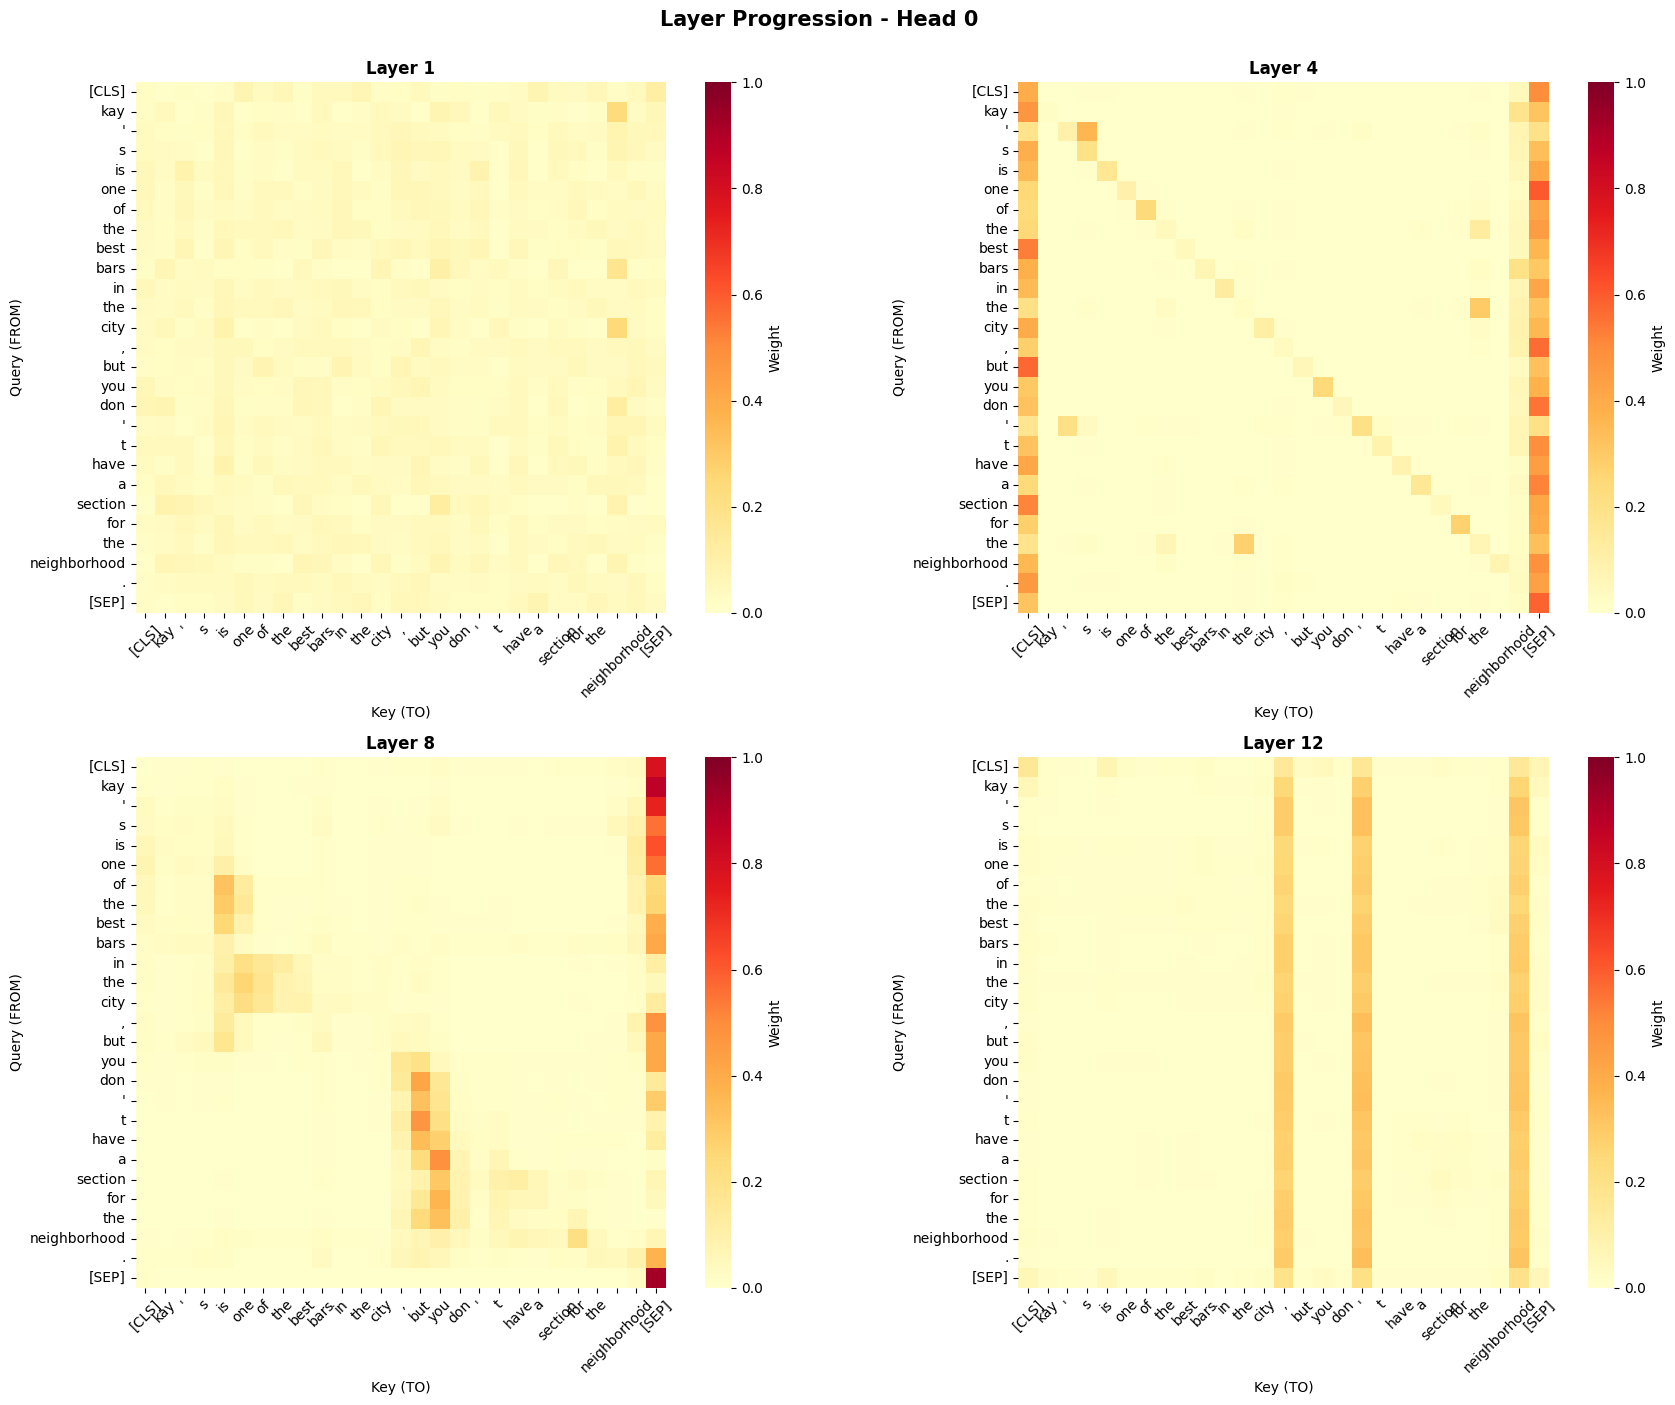

In [8]:
head_idx = 0
layers_to_compare = [0, 3, 7, 11]  # Layers 1, 4, 8, 12

print(f"Comparing Head {head_idx} across multiple layers...\n")

# SOLUTION: Extract attention by layer
attention_by_layer = []
for layer_idx in range(len(attention_weights)):
    attn_layer = attention_weights[layer_idx][0].cpu().numpy()  # (n_heads, seq_len, seq_len)
    attention_by_layer.append(attn_layer)

# SOLUTION: Plot progression
fig = plot_layer_progression(
    attention_by_layer,
    tokens,
    head=head_idx,
    layers=layers_to_compare,
    figsize=(18, 14)
)
plt.show()

---

# Summary

## Key Discoveries

Through this exercise, we discovered:

1. **Multi-Head Diversity:** Different heads specialize in different patterns (syntax, semantics, etc.)
2. **Hierarchical Learning:** Early layers = syntax, late layers = semantics
3. **Contextualized Understanding:** Same word gets different attention based on context
4. **Interpretability:** Attention weights reveal what the model "sees"

These insights are foundational to understanding modern LLMs!

## 🎉 Exercise Complete!

You've successfully analyzed attention patterns in a pretrained Transformer and uncovered how it learns hierarchical representations of language!